In [1]:
import os
import random
import math
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit_braket_provider import AWSBraketProvider, BraketLocalBackend
from dotenv import load_dotenv
# Load the API key from the .env file
load_dotenv()
IBMQ.save_account(os.getenv('IBM_TOKEN'))
IBMQ.load_account()

configrc.store_credentials:WARNING:2023-01-28 15:09:33,029: Credentials already present. Set overwrite=True to overwrite.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [36]:
from skimage.transform import resize
import imageio.v2 as image
from numpy import linalg as LA
import numpy as np

def encode_image(filepath, qubits):
    # Load the image data into a numpy array
    if filepath.endswith(".png") or filepath.endswith(".jpg"):
        image_data = image.imread(filepath)
    else:
        image_data=np.load(filepath)
    # Convert the image to grayscale
    image_data = np.dot(image_data[...,:3], [0.299, 0.587, 0.114])
    # Normalize the image
    image_data = image_data / LA.norm(image_data)
    # Resize the image
    image_data = resize(image_data, (int(np.sqrt(qubits)), int(np.sqrt(qubits))), anti_aliasing=True)
    # Flatten the image
    image_data = image_data.flatten()
    # Normalize the image
    image_data = image_data / LA.norm(image_data)
    return image_data

def encode_images(path="/home/josh/Repos/Logos/", qubits=16):
    encoded_images = {}
    files = os.listdir(path)
    for file in files:
        if file.endswith(".png") or file.endswith(".jpg"):
            encoded_images[file] = encode_image(path + file, qubits)
    return encoded_images

def decode_image(image, qubits, images=None, path="/home/josh/Repos/Logos/"):
    if images is None:
        images = encode_images(path, qubits)
    for img in images:
        if np.array_equal(images[img], image):
            return img
    return "Image not found"



In [37]:
path = "/home/josh/Repos/Logos/"
qubits = 16
images = encode_images(path, qubits)
len(images)


6

In [5]:
fp = "/home/josh/Repos/Logos/Wallpaper.jpg"
image_data = encode_image(fp, qubits)

In [6]:
decode_image(image_data, qubits, images)

'Wallpaper.jpg'

In [12]:
def get_circuit(qubits, image_data):
    # Create a quantum circuit
    qr = QuantumRegister(qubits)
    cr = ClassicalRegister(qubits)
    qc = QuantumCircuit(qr, cr)
    # Initialize the quantum circuit
    qc.initialize(image_data, qr)
    # Add the measurement
    qc.measure(qr, cr)
    return qc

qc = get_circuit(4, image_data)

In [13]:
qc.draw()

»
q0_0: »
      »
q0_1: »
      »
q0_2: »
      »
q0_3: »
      »
c0: 4/»
      »
«      ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q0_0: ┤0                                                                                                                                                     ├»
«      │                                                                                                                                                      │»
«q0_1: ┤1                                                                                                                                                     ├»
«      │  Initialize(0.010589,0.034829,0.035161,0.011702,0.12665,0.51696,0.48561,0.11636,0.14616,0.49077,0.42398,0.10129,0.032945,0.073937,0.070474,0.030092) │»
«q0_2: ┤2                                                                                                                                                     ├»
«      │                                                                                                                                                      │»
«q0_3: ┤3                                                                                                                                                     ├»
«      └──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘»
«c0: 4/════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════»
«                                                                                                                                                              »
«      ┌─┐         
«q0_0: ┤M├─────────
«      └╥┘┌─┐      
«q0_1: ─╫─┤M├──────
«       ║ └╥┘┌─┐   
«q0_2: ─╫──╫─┤M├───
«       ║  ║ └╥┘┌─┐
«q0_3: ─╫──╫──╫─┤M├
«       ║  ║  ║ └╥┘
«c0: 4/═╩══╩══╩══╩═
«       0  1  2  3

{'0010': 1, '0100': 16, '0001': 2, '0111': 12, '1011': 8, '1110': 8, '0101': 279, '1010': 179, '1101': 3, '0110': 247, '1000': 15, '1001': 254}


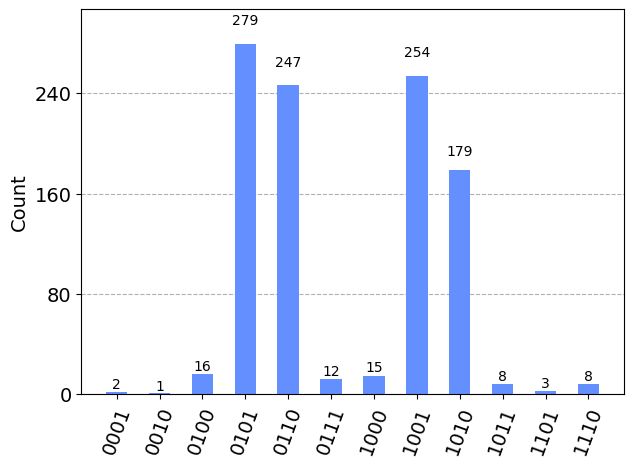

In [27]:
# Run the circuit on the local simulator
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1024)
result = job.result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts)